In [6]:
library(tidyverse)
library(effectsize)
library(pROC)
library(dplyr)
library(psych)


# Import Dataset

In [2]:
df <- read.csv("C:/Users/ZCooper/Documents/GitHub/longcovid/df_full.csv")
df_cs <- read.csv("C:/Users/ZCooper/Documents/GitHub/longcovid/df_CS.csv")
df_rct <- read.csv("C:/Users/ZCooper/Documents/GitHub/longcovid/df_RCT.csv")
df_rct_wide <- read.csv("C:/Users/ZCooper/Documents/GitHub/longcovid/df_RCT_wide.csv")

# Select Indices

## Original

In [3]:
# list of respiratory indices (taken at baseline)
vars <- c("mip_pre_max", "mip_pre_max_percentpredict_1", "mip_pre_max_percentpredict_2", "mip_pre_max_percentpredict_3", "mip_post_max_percentpredict_1", "mip_post_max_percentpredict_2", "mip_post_max_percentpredict_3", "smip_pre_max", "slopesmip_pre_max", "id_pre_max", "pif_pre_max", 
          "volume_pre_max", "sindex_pre_max", "sindex_pre_max_percentpredict", "fit_pre_max", "mip_post_max", "smip_post_max", "slopesmip_post_max", "id_post_max", "pif_post_max", 
          "volume_post_max", "sindex_post_max", "sindex_post_max_percentpredict", "fit_post_max")

## With PCA Variables

In [97]:
# Base respiratory variables
base_vars <- c("mip_pre_max", "mip_pre_max_percentpredict_1", "mip_pre_max_percentpredict_2", 
               "mip_post_max_percentpredict_1", "mip_post_max_percentpredict_2", "smip_pre_max", 
               "slopesmip_pre_max", "id_pre_max", "pif_pre_max", "volume_pre_max", "sindex_pre_max", 
               "sindex_pre_max_percentpredict", "fit_pre_max", "mip_post_max", "smip_post_max", 
               "slopesmip_post_max", "id_post_max", "pif_post_max", "volume_post_max", 
               "sindex_post_max", "sindex_post_max_percentpredict", "fit_post_max")

# PCA variables to potentially add
pca_vars <- c("respiratory_pca1_full", "respiratory_pca2_full", 
              "respiratory_pca1_strong", "respiratory_pca2_strong")

# Check which PCA variables exist in the dataframe
existing_pca_vars <- pca_vars[pca_vars %in% names(df_cs)]

# Combine base and existing PCA variables
vars <- c(base_vars, existing_pca_vars)

# Print what was included
cat("Variables included:\n")
cat("Base respiratory vars:", length(base_vars), "\n")
cat("PCA vars found:", length(existing_pca_vars), "->", paste(existing_pca_vars, collapse = ", "), "\n")
cat("Total vars:", length(vars), "\n")

Variables included:
Base respiratory vars: 22 
PCA vars found: 4 -> respiratory_pca1_full, respiratory_pca2_full, respiratory_pca1_strong, respiratory_pca2_strong 
Total vars: 26 


## With LASSO Composite

In [147]:
# Base respiratory variables
base_vars <- c("mip_pre_max", "mip_pre_max_percentpredict_1", "mip_pre_max_percentpredict_2", 
               "mip_post_max_percentpredict_1", "mip_post_max_percentpredict_2", "smip_pre_max", 
               "slopesmip_pre_max", "id_pre_max", "pif_pre_max", "volume_pre_max", "sindex_pre_max", 
               "sindex_pre_max_percentpredict", "fit_pre_max", "mip_post_max", "smip_post_max", 
               "slopesmip_post_max", "id_post_max", "pif_post_max", "volume_post_max", 
               "sindex_post_max", "sindex_post_max_percentpredict", "fit_post_max")

# LASSO variables to potentially add
lasso_vars <- c("respiratory_lasso")

# Check which LASSO variables exist in the dataframe
existing_lasso_vars <- lasso_vars[lasso_vars %in% names(df_cs)]

# Combine base and existing LASSO variables
vars <- c(base_vars, existing_lasso_vars)

# Print what was included
cat("Variables included:\n")
cat("Base respiratory vars:", length(base_vars), "\n")
cat("LASSO vars found:", length(existing_lasso_vars), "->", paste(existing_lasso_vars, collapse = ", "), "\n")
cat("Total vars:", length(vars), "\n")

Variables included:
Base respiratory vars: 22 
LASSO vars found: 1 -> respiratory_lasso 
Total vars: 23 


# PCA

## KMO Check

In [18]:
# Check correlations - you need a reasonably correlated matrix for PCA to be useful
cor_matrix <- cor(df_cs[vars], use = "complete.obs")

# Calculate the Kaiser-Meyer-Olkin (KMO) Measure of Sampling Adequacy
KMO(cor_matrix)

Kaiser-Meyer-Olkin factor adequacy
Call: KMO(r = cor_matrix)
Overall MSA =  0.58
MSA for each item = 
                   mip_pre_max   mip_pre_max_percentpredict_1 
                          0.58                           0.51 
  mip_pre_max_percentpredict_2   mip_pre_max_percentpredict_3 
                          0.53                           0.69 
 mip_post_max_percentpredict_1  mip_post_max_percentpredict_2 
                          0.48                           0.49 
 mip_post_max_percentpredict_3                   smip_pre_max 
                          0.69                           0.71 
             slopesmip_pre_max                     id_pre_max 
                          0.19                           0.45 
                   pif_pre_max                 volume_pre_max 
                          0.60                           0.45 
                sindex_pre_max  sindex_pre_max_percentpredict 
                          0.76                           0.56 
                

## PCA 8-24

Original sample size: 30 
Complete cases: 25 


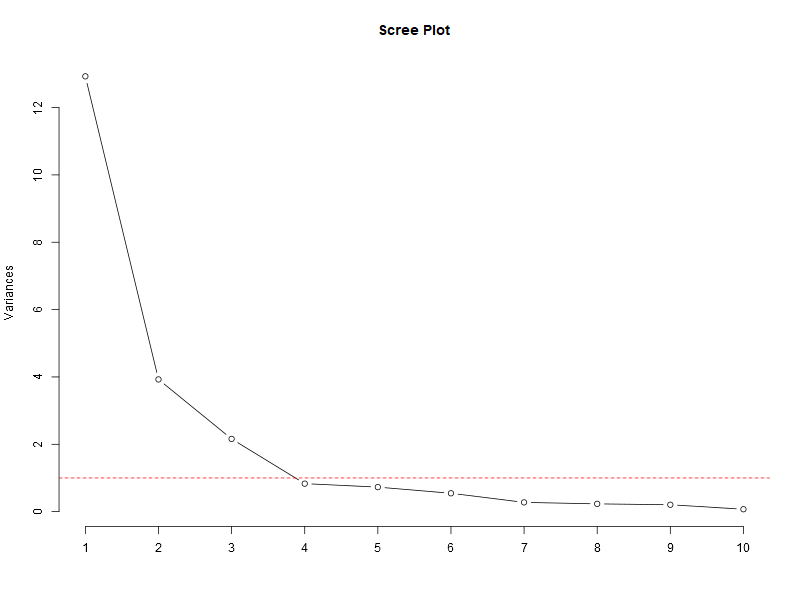

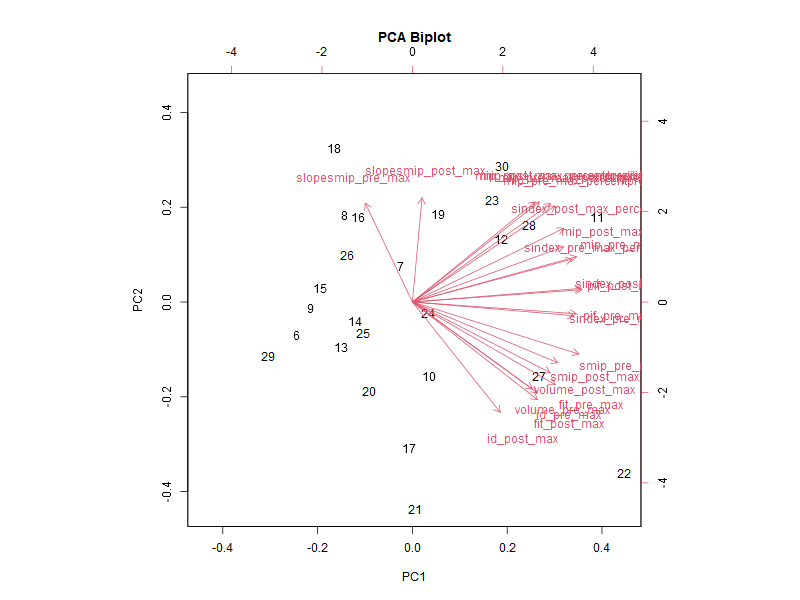

[1] "PC1 Loadings:"
[1] "PC2 Loadings:"
[1] "Variance explained by each PC:"
[1] 58.76 17.84  9.81  3.78  3.31


In [101]:
# Method 1: Use complete cases only
df_pca <- df_cs[vars]
df_pca_clean <- df_pca[complete.cases(df_pca), ]

cat("Original sample size:", nrow(df_pca), "\n")
cat("Complete cases:", nrow(df_pca_clean), "\n")

# Check if we have enough data left
if(nrow(df_pca_clean) < 10) {
  stop("Not enough complete cases for PCA")
}

# Run PCA on clean data
pca_result <- prcomp(df_pca_clean, center = TRUE, scale. = TRUE)

# Summary to see variance explained
summary(pca_result)

# Scree plot
screeplot(pca_result, type = "lines", main = "Scree Plot")
abline(h = 1, col = "red", lty = 2)

# Biplot
biplot(pca_result, main = "PCA Biplot")

# Component loadings
print("PC1 Loadings:")
sort(pca_result$rotation[,1], decreasing = TRUE)

print("PC2 Loadings:")
sort(pca_result$rotation[,2], decreasing = TRUE)

# Variance explained
variance_explained <- (pca_result$sdev^2 / sum(pca_result$sdev^2)) * 100
print("Variance explained by each PC:")
print(round(variance_explained[1:5], 2))

=== PC1 Loadings (Sorted) ===
                                                     Variable         PC1
pif_post_max                                     pif_post_max  0.26056106
sindex_post_max                               sindex_post_max  0.25949151
smip_pre_max                                     smip_pre_max  0.25584784
mip_pre_max                                       mip_pre_max  0.25235610
pif_pre_max                                       pif_pre_max  0.25213892
sindex_pre_max                                 sindex_pre_max  0.24816364
sindex_pre_max_percentpredict   sindex_pre_max_percentpredict  0.24560409
sindex_post_max_percentpredict sindex_post_max_percentpredict  0.23277880
mip_post_max                                     mip_post_max  0.23275130
smip_post_max                                   smip_post_max  0.22350119
fit_pre_max                                       fit_pre_max  0.21978410
mip_pre_max_percentpredict_1     mip_pre_max_percentpredict_1  0.21927930
mip_pre_

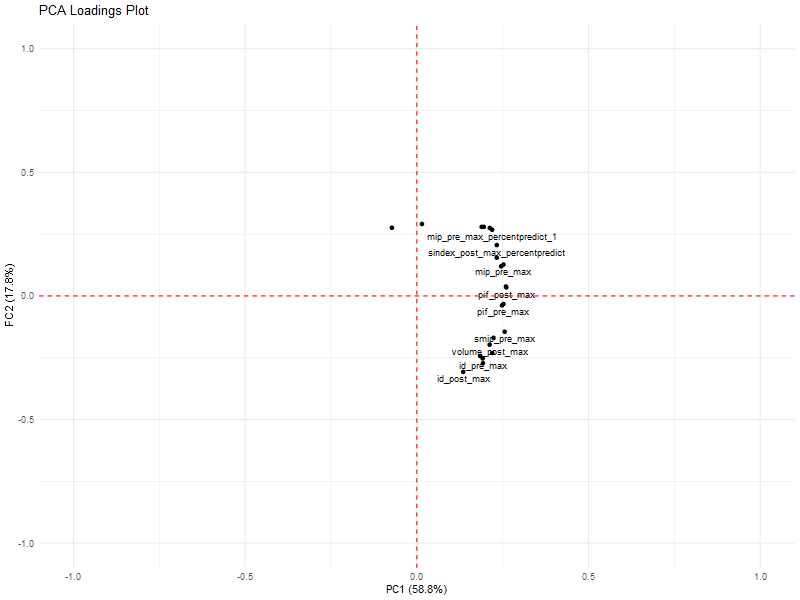

In [102]:
# Create a dataframe of the loadings for the first two components
loadings_df <- as.data.frame(pca_result$rotation[, 1:2])
loadings_df$Variable <- rownames(loadings_df)

# Sort the loadings for PC1 to see which variables contribute most
cat("=== PC1 Loadings (Sorted) ===\n")
pc1_sorted <- loadings_df[order(-abs(loadings_df$PC1)), c("Variable", "PC1")]
print(pc1_sorted)

# Sort the loadings for PC2 to see which variables contribute most
cat("\n=== PC2 Loadings (Sorted) ===\n")
pc2_sorted <- loadings_df[order(-abs(loadings_df$PC2)), c("Variable", "PC2")]
print(pc2_sorted)

# You can also make a plot to visualize this
library(ggplot2)
ggplot(loadings_df, aes(x = PC1, y = PC2, label = Variable)) +
  geom_point() +
  geom_text(size = 3, hjust = 0.5, vjust = 1.5, check_overlap = TRUE) +
  geom_hline(yintercept = 0, linetype = "dashed", color = "red") +
  geom_vline(xintercept = 0, linetype = "dashed", color = "red") +
  xlim(-1, 1) + ylim(-1, 1) +
  labs(title = "PCA Loadings Plot",
       x = paste0("PC1 (", round(variance_explained[1], 1), "%)"),
       y = paste0("PC2 (", round(variance_explained[2], 1), "%)")) +
  theme_minimal()

## PCA 8-25

In [96]:
# --- 1. Define your variables ---
df_pca <- df_cs[vars]

# --- 2. Full PCA (all variables) ---
df_pca_clean <- df_pca[complete.cases(df_pca), ]
pca_full <- prcomp(df_pca_clean, center = TRUE, scale. = TRUE)

# Scores for full PCA (align with row order)
scores_full <- predict(pca_full, newdata = scale(df_pca, center=TRUE, scale=TRUE))
df_cs$respiratory_pca1_full <- scores_full[,1]
df_cs$respiratory_pca2_full <- scores_full[,2]

# --- 3. Identify strong loadings (|≥0.25| for PC1 or PC2) ---
loadings <- pca_full$rotation[,1:2]
strong_vars <- rownames(loadings)[apply(abs(loadings) >= 0.25, 1, any)]
print(strong_vars)

# --- 4. PCA on strong subset only ---
df_pca_strong <- df_cs[strong_vars]
df_pca_strong_clean <- df_pca_strong[complete.cases(df_pca_strong), ]
pca_strong <- prcomp(df_pca_strong_clean, center = TRUE, scale. = TRUE)

scores_strong <- predict(pca_strong, newdata = scale(df_pca_strong, center=TRUE, scale=TRUE))
df_cs$respiratory_pca1_strong <- scores_strong[,1]
df_cs$respiratory_pca2_strong <- scores_strong[,2]

# --- 5. Inspect result ---
cat("Strongly loading variables used:", strong_vars, "\n")
summary(pca_full)
summary(pca_strong)


 [1] "mip_pre_max"                   "mip_pre_max_percentpredict_1" 
 [3] "mip_pre_max_percentpredict_2"  "mip_post_max_percentpredict_1"
 [5] "mip_post_max_percentpredict_2" "smip_pre_max"                 
 [7] "slopesmip_pre_max"             "id_pre_max"                   
 [9] "pif_pre_max"                   "slopesmip_post_max"           
[11] "id_post_max"                   "pif_post_max"                 
[13] "sindex_post_max"               "fit_post_max"                 
Strongly loading variables used: mip_pre_max mip_pre_max_percentpredict_1 mip_pre_max_percentpredict_2 mip_post_max_percentpredict_1 mip_post_max_percentpredict_2 smip_pre_max slopesmip_pre_max id_pre_max pif_pre_max slopesmip_post_max id_post_max pif_post_max sindex_post_max fit_post_max 


# Discriminatory Validity

## PCS vs Healthy Controls

### ROC AUC + Youden J + Sensitivity/Specificity

In [4]:
# ---- packages ---- 
library(dplyr)
library(pROC)
library(binom)     # for exact binomial CIs on sens/spec
library(effectsize)

# ---- loop ---- 
roc_tbl <- list() 

for (v in vars) {
  r <- roc(df_cs$covid_group, df_cs[[v]], quiet = TRUE, direction = ">")
  auc_ci <- ci.auc(r)
  
  # Youden cutpoint
  best <- coords(r, "best", best.method = "youden",
                 ret = c("threshold","sensitivity","specificity","tp","tn","fp","fn"))
  

  # Extract values more safely
  tp_val <- as.numeric(best$tp[1])  # Use $ notation and take first element
  fn_val <- as.numeric(best$fn[1])
  tn_val <- as.numeric(best$tn[1]) 
  fp_val <- as.numeric(best$fp[1])
  
  # Check for NA values
  if(any(is.na(c(tp_val, fn_val, tn_val, fp_val)))) {
    print("Warning: NA values detected")
    next
  }
  
  # sens/spec CIs
  sens_ci <- binom.exact(tp_val, tp_val + fn_val)
  spec_ci <- binom.exact(tn_val, tn_val + fp_val)
  
  # Cohen's d (LC vs HC)
  d_val <- cohens_d(as.formula(paste(v, "~ covid_group")), data = df_cs)$Cohens_d
   
  roc_tbl[[v]] <- tibble(
    Variable = v,
    AUC = as.numeric(auc(r)),
    AUC_low = as.numeric(auc_ci[1]),
    AUC_high = as.numeric(auc_ci[3]),
    Youden_J = as.numeric(best$sensitivity[1] + best$specificity[1] - 1),
    Cutpoint = as.numeric(best$threshold[1]),
    Sens = as.numeric(best$sensitivity[1]),
    Sens_low = sens_ci$lower,
    Sens_high = sens_ci$upper,
    Spec = as.numeric(best$specificity[1]),
    Spec_low = spec_ci$lower,
    Spec_high = spec_ci$upper,
    Cohens_d = d_val
  )
}

roc_results <- bind_rows(roc_tbl) %>% arrange(desc(AUC))
write.csv(roc_results, "cs_roc_results.csv", row.names = FALSE)
print("Saved to cs_roc_results.csv")

Warning message:
package ‘binom’ was built under R version 4.3.3 
Warning messages:
1: Missing values detected. NAs dropped. 
2: Missing values detected. NAs dropped. 
3: Missing values detected. NAs dropped. 
4: Missing values detected. NAs dropped. 


[1] "Saved to cs_roc_results.csv"


### Chart ROC

Setting levels: control = 0, case = 1


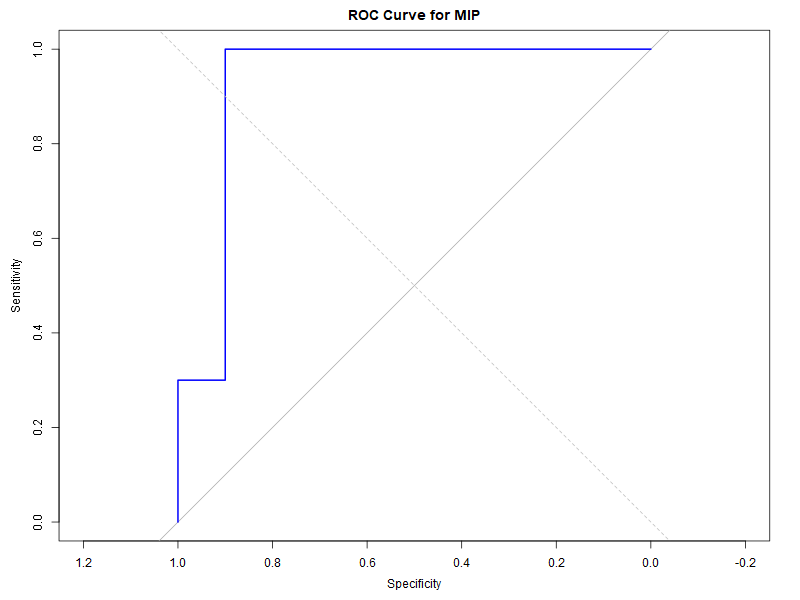

In [20]:
# Example with one variable
r <- roc(df_cs$covid_group, df_cs$mip_pre_max, direction = ">")

plot(r, col = "blue", lwd = 2, main = "ROC Curve for MIP")
abline(a = 0, b = 1, lty = 2, col = "gray")  # diagonal line


Setting levels: control = 0, case = 1
Setting levels: control = 0, case = 1
Setting levels: control = 0, case = 1
Setting levels: control = 0, case = 1
Setting levels: control = 0, case = 1
Setting levels: control = 0, case = 1
Setting levels: control = 0, case = 1
Setting levels: control = 0, case = 1
Setting levels: control = 0, case = 1
Setting levels: control = 0, case = 1
Setting levels: control = 0, case = 1
Setting levels: control = 0, case = 1
Setting levels: control = 0, case = 1
Setting levels: control = 0, case = 1
Setting levels: control = 0, case = 1
Setting levels: control = 0, case = 1
Setting levels: control = 0, case = 1
Setting levels: control = 0, case = 1
Setting levels: control = 0, case = 1
Setting levels: control = 0, case = 1
Setting levels: control = 0, case = 1
Setting levels: control = 0, case = 1
Setting levels: control = 0, case = 1
Setting levels: control = 0, case = 1


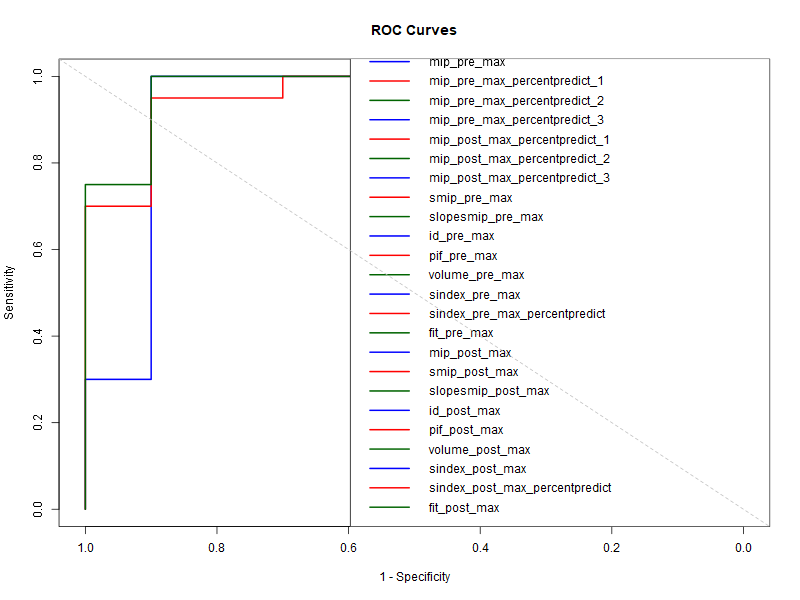

In [21]:
vars_to_plot <- vars
colors <- c("blue", "red", "darkgreen")

plot(NULL, xlim=c(1,0), ylim=c(0,1), 
     xlab="1 - Specificity", ylab="Sensitivity", 
     main="ROC Curves")

for (i in seq_along(vars_to_plot)) {
  v <- vars_to_plot[i]
  r <- roc(df_cs$covid_group, df_cs[[v]], direction = ">")
  plot(r, col = colors[i], lwd = 2, add = TRUE)
}

legend("bottomright", legend=vars_to_plot, col=colors, lwd=2)
abline(a = 0, b = 1, lty = 2, col = "gray")


### Compare AUCs (DeLong)

In [8]:
# Example: compare S-Index vs MIP
r_mip <- roc(df_cs$covid_group, df_cs$mip_pre_max, quiet=TRUE)
r_sidx <- roc(df_cs$covid_group, df_cs$id_pre_max, quiet=TRUE)
roc.test(r_mip, r_sidx, method = "delong")


	DeLong's test for two correlated ROC curves

data:  r_mip and r_sidx
Z = 1.2236, p-value = 0.2211
alternative hypothesis: true difference in AUC is not equal to 0
95 percent confidence interval:
 -0.08424808  0.36424808
sample estimates:
AUC of roc1 AUC of roc2 
  0.9333333   0.7933333 


### Lasso

#### 8-25

In [136]:
library(glmnet)

# predictors matrix (complete cases across chosen variables)
dat_lasso <- df_cs %>% select(all_of(vars), covid_group) %>% na.omit()
x <- as.matrix(dat_lasso %>% select(-covid_group))
y <- dat_lasso$covid_group

set.seed(123)
cvfit <- cv.glmnet(x, y, family = "binomial", alpha = 1, nfolds = 5, standardize = TRUE)
cvfit$lambda.min; cvfit$lambda.1se

# non-zero coefficients at the more parsimonious lambda.1se
coef_1se <- coef(cvfit, s = "lambda.1se")
keep <- which(as.numeric(coef_1se) != 0)
lasso_keep <- rownames(coef_1se)[keep]
print(lasso_keep)

# predicted probs and AUC
pred <- as.numeric(predict(cvfit, newx = x, s = "lambda.1se", type = "response"))
auc(cvfit_roc <- roc(y, pred, quiet=TRUE))
ci.auc(cvfit_roc)

# Check coefficients at lambda.min
coef_min <- coef(cvfit, s = "lambda.min")
print(coef_min)


Warning messages:
1: In lognet(x, is.sparse, y, weights, offset, alpha, nobs, nvars,  :
  one multinomial or binomial class has fewer than 8  observations; dangerous ground
2: In lognet(x, is.sparse, y, weights, offset, alpha, nobs, nvars,  :
  one multinomial or binomial class has fewer than 8  observations; dangerous ground


[1] "(Intercept)"                  "mip_pre_max"                 
[3] "mip_pre_max_percentpredict_2"
23 x 1 sparse Matrix of class "dgCMatrix"
                                  lambda.min
(Intercept)                     5.1984112120
mip_pre_max                    -0.0079292231
mip_pre_max_percentpredict_1    .           
mip_pre_max_percentpredict_2   -0.0370004352
mip_post_max_percentpredict_1   .           
mip_post_max_percentpredict_2  -0.0118854448
smip_pre_max                   -0.0008901074
slopesmip_pre_max               .           
id_pre_max                      .           
pif_pre_max                     .           
volume_pre_max                  .           
sindex_pre_max                  .           
sindex_pre_max_percentpredict  -0.0085558882
fit_pre_max                     .           
mip_post_max                    .           
smip_post_max                   .           
slopesmip_post_max              .           
id_post_max                     .           
pi

#### 8-26

In [12]:
library(glmnet)
library(dplyr)

# predictors matrix (complete cases across chosen variables)
dat_lasso <- df_cs %>% select(all_of(vars), covid_group) %>% na.omit()
x <- as.matrix(dat_lasso %>% select(-covid_group))
y <- dat_lasso$covid_group

set.seed(123)
cvfit <- cv.glmnet(x, y, family = "binomial", alpha = 1, nfolds = 5, standardize = TRUE)
cvfit$lambda.min; cvfit$lambda.1se

# non-zero coefficients at the more parsimonious lambda.1se
coef_1se <- coef(cvfit, s = "lambda.1se")
keep <- which(as.numeric(coef_1se) != 0)
lasso_keep <- rownames(coef_1se)[keep]
print(lasso_keep)

# predicted probs and AUC
pred <- as.numeric(predict(cvfit, newx = x, s = "lambda.1se", type = "response"))
auc(cvfit_roc <- roc(y, pred, quiet=TRUE))
ci.auc(cvfit_roc)

# Check coefficients at lambda.min
coef_min <- coef(cvfit, s = "lambda.min")
print(coef_min)

# --- CREATE COMPOSITE SCORE ---
# Option 1: Use lambda.1se (more parsimonious)
lasso_coefs <- coef(cvfit, s = "lambda.1se")

# Initialize the column with NA
df_cs$respiratory_lasso <- NA

# For all rows in df_cs, calculate the linear combination
# First, create a matrix for ALL rows in df_cs (with standardization)
x_all <- as.matrix(df_cs[vars])

# Handle missing values by setting them to the mean (what glmnet does during standardization)
for(i in 1:ncol(x_all)) {
  col_mean <- mean(x_all[,i], na.rm = TRUE)
  col_sd <- sd(x_all[,i], na.rm = TRUE)
  x_all[is.na(x_all[,i]), i] <- col_mean
  # Standardize (same as glmnet does internally)
  x_all[,i] <- (x_all[,i] - col_mean) / col_sd
}

# Calculate linear combination (exclude intercept from matrix multiplication)
intercept <- as.numeric(lasso_coefs[1])
beta_coefs <- as.numeric(lasso_coefs[-1])  # Remove intercept

# Calculate the composite score (linear combination)
df_cs$respiratory_lasso <- intercept + as.numeric(x_all %*% beta_coefs)
# After creating the original respiratory_lasso score, flip it
df_cs$respiratory_lasso <- -df_cs$respiratory_lasso

# --- VERIFICATION ---
# Check that our manual calculation matches glmnet for complete cases
manual_scores_complete <- df_cs$respiratory_lasso[complete.cases(df_cs[vars])]
glmnet_scores <- as.numeric(predict(cvfit, newx = x, s = "lambda.1se", type = "link"))

cat("Manual vs glmnet scores correlation:", cor(manual_scores_complete, glmnet_scores), "\n")
cat("Max difference:", max(abs(manual_scores_complete - glmnet_scores)), "\n")

# --- SUMMARY ---
cat("\nLASSO Composite Score Summary:\n")
cat("Non-zero coefficients:", length(lasso_keep)-1, "\n")  # -1 for intercept
cat("Variables selected:", paste(lasso_keep[-1], collapse = ", "), "\n")
summary(df_cs$respiratory_lasso)

Loading required package: Matrix

Attaching package: ‘Matrix’

The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack

Loaded glmnet 4.1-10


: Error in `all_of()`:
! Can't subset columns that don't exist.
✖ Columns `mip_pre_max_percentpredict_3` and `mip_post_max_percentpredict_3` don't exist.

### Prediction Model

#### Complex

In [134]:
final_model <- glm(covid_group ~ mip_pre_max + mip_pre_max_percentpredict_2 +
                   mip_post_max_percentpredict_2 + smip_pre_max +
                   slopesmip_pre_max + sindex_pre_max_percentpredict,
                   data = df_cs, family = "binomial")
summary(final_model)


Call:
glm(formula = covid_group ~ mip_pre_max + mip_pre_max_percentpredict_2 + 
    mip_post_max_percentpredict_2 + smip_pre_max + slopesmip_pre_max + 
    sindex_pre_max_percentpredict, family = "binomial", data = df_cs)

Coefficients:
                               Estimate Std. Error z value Pr(>|z|)  
(Intercept)                   10.269949   5.825753   1.763   0.0779 .
mip_pre_max                    0.017073   0.169885   0.100   0.9199  
mip_pre_max_percentpredict_2  -0.104504   0.215697  -0.484   0.6280  
mip_post_max_percentpredict_2 -0.023671   0.122760  -0.193   0.8471  
smip_pre_max                  -0.001571   0.009952  -0.158   0.8745  
slopesmip_pre_max              0.092606   0.204507   0.453   0.6507  
sindex_pre_max_percentpredict -0.049935   0.106930  -0.467   0.6405  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 33.6506  on 24  degrees of freedom
Residual deviance:  6.

## Dyspnea vs No Dyspnea

### ROC AUC + Youden

In [57]:
# ---- packages ---- 
library(dplyr)
library(pROC)
library(binom)     # for exact binomial CIs on sens/spec
library(effectsize)

# ---- loop ---- 
roc_tbl <- list() 

for (v in vars) {
  r <- roc(df_cs$mmrc_dichotomous, df_cs[[v]], quiet = TRUE, direction = ">")
  auc_ci <- ci.auc(r)
  
  # Youden cutpoint
  best <- coords(r, "best", best.method = "youden",
                 ret = c("threshold","sensitivity","specificity","tp","tn","fp","fn"))
  
  # Extract values more safely
  tp_val <- as.numeric(best$tp[1])  # Use $ notation and take first element
  fn_val <- as.numeric(best$fn[1])
  tn_val <- as.numeric(best$tn[1]) 
  fp_val <- as.numeric(best$fp[1])
  
  # Check for NA values
  if(any(is.na(c(tp_val, fn_val, tn_val, fp_val)))) {
    print("Warning: NA values detected")
    next
  }
  
  # sens/spec CIs
  sens_ci <- binom.exact(tp_val, tp_val + fn_val)
  spec_ci <- binom.exact(tn_val, tn_val + fp_val)
  
  # Cohen's d (Dyspnea vs No Dyspnea)
  d_val <- cohens_d(as.formula(paste(v, "~ mmrc_dichotomous")), data = df_cs)$Cohens_d
   
  roc_tbl[[v]] <- tibble(
    Variable = v,
    AUC = as.numeric(auc(r)),
    AUC_low = as.numeric(auc_ci[1]),
    AUC_high = as.numeric(auc_ci[3]),
    Youden_J = as.numeric(best$sensitivity[1] + best$specificity[1] - 1),
    Cutpoint = as.numeric(best$threshold[1]),
    Sens = as.numeric(best$sensitivity[1]),
    Sens_low = sens_ci$lower,
    Sens_high = sens_ci$upper,
    Spec = as.numeric(best$specificity[1]),
    Spec_low = spec_ci$lower,
    Spec_high = spec_ci$upper,
    Cohens_d = d_val
  )
}

roc_results <- bind_rows(roc_tbl) %>% arrange(desc(AUC))
print(roc_results, width=Inf)

Warning messages:
1: Missing values detected. NAs dropped. 
2: Missing values detected. NAs dropped. 
3: Missing values detected. NAs dropped. 
4: Missing values detected. NAs dropped. 


# A tibble: 20 × 13
   Variable                        AUC AUC_low AUC_high Youden_J Cutpoint
   <chr>                         <dbl>   <dbl>    <dbl>    <dbl>    <dbl>
 1 mip_post_max                  0.891   0.779    1        0.688    75   
 2 sindex_post_max               0.877   0.756    0.999    0.688    67.5 
 3 pif_post_max                  0.868   0.742    0.994    0.688     3.95
 4 mip_post_max_percentpredict_1 0.866   0.740    0.992    0.580    48.8 
 5 mip_post_max_percentpredict_2 0.857   0.726    0.988    0.616    65.5 
 6 smip_pre_max                  0.848   0.694    1        0.688   419   
 7 id_pre_max                    0.847   0.680    1        0.667     5.26
 8 fit_pre_max                   0.817   0.649    0.985    0.679    13   
 9 pif_pre_max                   0.808   0.650    0.966    0.625     3.65
10 sindex_pre_max                0.806   0.646    0.965    0.625    63.5 
11 smip_post_max                 0.804   0.638    0.970    0.616   302   
12 mip_pre_max    

### Compare AUCs (Delong)

In [58]:
# Example: compare S-Index vs MIP
r_mip <- roc(df_cs$mmrc_dichotomous, df_cs$mip_pre_max, quiet=TRUE)
r_sidx <- roc(df_cs$mmrc_dichotomous, df_cs$sindex_pre_max, quiet=TRUE)
print(roc.test(r_mip, r_sidx, method = "delong"))



	DeLong's test for two correlated ROC curves

data:  r_mip and r_sidx
Z = -0.25375, p-value = 0.7997
alternative hypothesis: true difference in AUC is not equal to 0
95 percent confidence interval:
 -0.1752564  0.1350779
sample estimates:
AUC of roc1 AUC of roc2 
  0.7857143   0.8058036 



# Convergent Validity

## BDI vs Index

In [74]:
# Initialize list to store results
convergent_results <- list()

# Loop through each respiratory variable
for (v in vars) {
  
  # Create complete cases dataset for this analysis
  temp_df <- df_cs[complete.cases(df_cs[, c("bdi_sum", v, "data_age", "subject_female")]), ]
  
  # Skip if not enough data
  if (nrow(temp_df) < 10) {
    message("Skipping ", v, ": insufficient data (n = ", nrow(temp_df), ")")
    next
  }
  
  # 1. CORRELATION ANALYSIS (Spearman - good for BDI Likert scale)
  cor_test <- cor.test(temp_df[[v]], temp_df$bdi_sum, method = "pearson")
  
  # 2. LINEAR REGRESSION (controlling for age and sex)
  formula <- as.formula(paste("bdi_sum ~", v, "+ data_age + subject_female"))
  lm_model <- lm(formula, data = temp_df)
  lm_summary <- summary(lm_model)
  
  # 3. CHECK REGRESSION ASSUMPTIONS
  # Normality of residuals
  shapiro_test <- shapiro.test(residuals(lm_model))
  
  # 4. EXTRACT KEY RESULTS
  convergent_results[[v]] <- list(
    variable = v,
    n = nrow(temp_df),
    
    # Correlation results
    correlation = list(
      rho = cor_test$estimate,
      p_value = cor_test$p.value,
      ci_low = cor_test$conf.int[1],
      ci_high = cor_test$conf.int[2]
    ),
    
    # Regression results
    regression = list(
      formula = format(formula),
      r_squared = lm_summary$r.squared,
      adj_r_squared = lm_summary$adj.r.squared,
      f_statistic = lm_summary$fstatistic[1],
      f_p_value = pf(lm_summary$fstatistic[1], 
                     lm_summary$fstatistic[2], 
                     lm_summary$fstatistic[3], 
                     lower.tail = FALSE)
    ),
    
    # Key coefficient for the respiratory variable (adjusted for age/sex)
    main_effect = list(
      estimate = lm_summary$coefficients[v, "Estimate"],
      std_error = lm_summary$coefficients[v, "Std. Error"],
      t_value = lm_summary$coefficients[v, "t value"],
      p_value = lm_summary$coefficients[v, "Pr(>|t|)"],
      conf_low = confint(lm_model)[v, 1],
      conf_high = confint(lm_model)[v, 2],
      standardized_beta = lm_summary$coefficients[v, "Estimate"] * sd(temp_df[[v]]) / sd(temp_df$bdi_sum)
    ),
    
    # Assumption checks
    assumptions = list(
      residuals_normal = shapiro_test$p.value > 0.05,
      shapiro_p = shapiro_test$p.value
    )
  )
}

# Create a clean summary table for interpretation
summary_table <- do.call(rbind, lapply(convergent_results, function(x) {
  data.frame(
    Variable = x$variable,
    N = x$n,
    Correlation_rho = round(x$correlation$rho, 3),
    Correlation_p = round(x$correlation$p_value, 3),
    Beta = round(x$main_effect$estimate, 3),
    Std_Beta = round(x$main_effect$standardized_beta, 3),
    SE = round(x$main_effect$std_error, 3),
    Beta_p = round(x$main_effect$p_value, 3),
    CI_95 = paste0("[", round(x$main_effect$conf_low, 2), ", ", 
                   round(x$main_effect$conf_high, 2), "]"),
    R_squared = round(x$regression$r_squared, 3),
    Residuals_normal = x$assumptions$residuals_normal
  )
}))

# Sort by absolute correlation strength (strongest relationships first)
summary_table <- summary_table[order(-abs(summary_table$Correlation_rho)), ]

# Print the results
print(summary_table)

                                                     Variable  N
mip_post_max_percentpredict_2   mip_post_max_percentpredict_2 30
mip_post_max_percentpredict_1   mip_post_max_percentpredict_1 30
mip_pre_max_percentpredict_2     mip_pre_max_percentpredict_2 30
mip_post_max                                     mip_post_max 30
sindex_post_max_percentpredict sindex_post_max_percentpredict 30
mip_pre_max_percentpredict_1     mip_pre_max_percentpredict_1 30
sindex_pre_max_percentpredict   sindex_pre_max_percentpredict 30
smip_pre_max                                     smip_pre_max 30
mip_pre_max                                       mip_pre_max 30
fit_pre_max                                       fit_pre_max 30
smip_post_max                                   smip_post_max 30
id_pre_max                                         id_pre_max 25
pif_post_max                                     pif_post_max 30
sindex_post_max                               sindex_post_max 30
fit_post_max             

## Lasso Logistic

In [77]:
library(glmnet)

# predictors matrix (complete cases across chosen variables)
dat_lasso <- df_cs %>% select(all_of(resp_vars), covid_group) %>% na.omit()
x <- as.matrix(dat_lasso %>% select(-covid_group))
y <- dat_lasso$covid_group

set.seed(123)
cvfit <- cv.glmnet(x, y, family = "binomial", alpha = 1, nfolds = 10, standardize = TRUE)
cvfit$lambda.min; cvfit$lambda.1se

# non-zero coefficients at the more parsimonious lambda.1se
coef_1se <- coef(cvfit, s = "lambda.1se")
keep <- which(as.numeric(coef_1se) != 0)
lasso_keep <- rownames(coef_1se)[keep]
print(lasso_keep)

# predicted probs and AUC
pred <- as.numeric(predict(cvfit, newx = x, s = "lambda.1se", type = "response"))
auc(cvfit_roc <- roc(y, pred, quiet=TRUE))
ci.auc(cvfit_roc)

# Check coefficients at lambda.min
coef_min <- coef(cvfit, s = "lambda.min")
print(coef_min)


[1] "(Intercept)"  "mip_pre_max"  "mip_post_max"
13 x 1 sparse Matrix of class "dgCMatrix"
                 lambda.min
(Intercept)      5.25944715
mip_pre_max     -0.04614875
smip_pre_max     .         
pif_pre_max      .         
sindex_pre_max   .         
volume_pre_max   .         
fit_pre_max      .         
mip_post_max    -0.01717136
smip_post_max    .         
pif_post_max     .         
sindex_post_max  .         
volume_post_max  .         
fit_post_max     .         
